# Introduction to FMU interoperability in CasADi
Joel Andersson (joel@fmiopt.com) Joris Gillis (joris@yacoda.com)

16th International Modelica Conference,

Lucerne, September 8, 2025

## CasADi and Modelica/FMI
 * Modelica interoperability was the original motivation to start developing CasADi
   - vICERP project, anno ~2010
 * Multiple paths have been explored
   - JModelica.org/OpenModelica -> FMUX -> CasADi
     * FMUX: FMI 1.0 with model equations added to the FMI XML
   - Direct symbolic coupling to CasADi
     - JModelica.org
     - Modelon Impact / OCT
     - Pymoca
   - Since ~2020: **Support for standard FMUs in CasADi** (focus here)
     - New foreign function interface in CasADi, interacts directly with the FMI C and XML APIs
     - Still not mature, but increasingly useful in actual application

## FMI import in CasADi

### Obtaining CasADi
If you haven't already, make sure have installed CasADi. The following tutorial assumes CasADi 3.7.1 or later.
CasADi can be installed using pip:

In [1]:
# Install CasADi (uncomment if needed)
#!pip install casadi

We also need matplotlib for plotting.

In [2]:
# Install matplotlib (uncomment if needed)
#!pip install matplotlib

### A Modelica race car example
We will consider a race car described by a so-called "bicycle model", as described in

*NMPC for Racing Using a Singularity-Free Path-Parametric Model with Obstacle Avoidance* by Kloeser et al (2020): \
https://www.sciencedirect.com/science/article/pii/S2405896320317845
https://publications.syscop.de/Kloeser2020.pdf

![car_racing_an_oval_track](figures/car_racing_an_oval_track.svg)

The model in that paper can be written in Modelica as follows:

In [3]:
# Toy example: Van der Pol oscillator
mofile = 'Kloeser2020.mo'
with open(mofile, 'r') as myfile: print(myfile.read())

model Kloeser2020 "Bicycle model of a model race car, from Kloeser2020 paper"
  import Modelica.Math.*;

  // --- Parameters (Table 1 from Kloeser2020) ---
  parameter Real m    = 0.043  "Mass [kg]";
  parameter Real lr   = 0.025  "Rear length [m]";
  parameter Real lf   = 0.025  "Front length [m]";
  parameter Real cm1  = 0.28;
  parameter Real cm2  = 0.05;
  parameter Real cr0  = 0.006;
  parameter Real cr2  = 0.011;
  parameter Real cr3  = 5.0;

  // Constant curvature (circle)
  Real kappa "Road curvature [1/m] (constant)";

  // --- Inputs ---
  input Real D_der(min = -20.0, max = 20.0)     "Rate of electric motor duty cycle";
  input Real delta_der(min = -4.0, max = 4.0) "Rate of steering angle";

  Real D(min = -1, max = 1, start = 0)         "Duty cycle of electric motor";
  Real delta(min = -0.8, max = 0.8, start = 0) "Steering angle";
  
  // --- Outputs ---
  output Real acc_long "Longitudinal acceleration";
  output Real acc_lat  "Lateral acceleration";
  
  output Real p_x

We assume an oval race track with no banking, consisting of two half circles and two straight segments.

The main variables of the problem are sketched below.
![car_coordinates](figures/car_coordinates.svg)

For details about the model equations, we refer to the above article.

### Compiling the model into an FMU

 * The Functional Mockup Interface (FMI) provides a standardized interface to dynamic systems
   - While a Modelica Association Project, it is not limited to Modelica
   - Started in 2010, it is now at version 3 and supported by 250+ tools
 * The standard describe Functional Mockup Units (FMUs) which are ZIP archives, containing a number of files, in particular
   - an XML adhering to the FMI XML API, and 
   - one or more dynamically linked libraries (DLLs), adhering to the FMI C API
 * An FMU with support for *model exchange* exposes the lower-level DAE formulation we need for dynamic optimization
   - Support for *co-simulation* can be used to validate simulation results, but is of limited use for gradient-based optimization
 * In today's tutorial, all FMUs have been generated by OpenModelica and cross-compiled for Windows, Linux & Mac (Apple or Intel silicon)

In [4]:
from pathlib import Path
fmu_file = Path.cwd() / 'fmus' / 'kloeser2020.fmu'
print(f'Using precompiled FMU: {fmu_file}')

Using precompiled FMU: /home/jaeandersson/projects/modelica_2025_workshop/fmus/kloeser2020.fmu


## DaeBuilder instances
* CasADi supports the import of model exchange FMI 2 and FMI 3
* Unlike other external interfaces in CasADi, FMUs are imported in two steps:
  * First, a *mutable* `casadi.DaeBuilder` instance is created
  * Then, one or more *immutable* `casadi.FmuFunction` instances are created
* To create a `casadi.DaeBuilder` instance from an FMU, pass a desired name for the instance and the path to the FMU
  * You can pass either the unzipped FMU directory, or the original FMU. In the latter case, CasADi will unzip it into a temporary directory.
  * Only the FMI XML API is used to create the `casadi.DaeBuilder` instance
  * Mutable: Can manipulate after creation

In [5]:
# Use FMU to create a CasADi/DaeBuilder instance
import casadi as ca
dae = ca.DaeBuilder('racecar', str(fmu_file))
dae.disp(True)

nx = 6, nz = 0, nq = 0, ny = 8, np = 0, nc = 8, nd = 0, nw = 22, nu = 2
Model variables:
  c = [cm1, cm2, cr0, cr2, cr3, lf, lr, m]
  x = [D, alpha, delta, n, s, v]
  w = [der(D), der(alpha), der(delta), der(n), der(s), der(v), Fx_d, acc_lat, acc_long, beta, c_x, c_y, dalpha, dn, ds, dv, e_n_x, e_n_y, kappa, p_x, p_y, s_mod]
  u = [D_der, delta_der]
List of constants (c):
  cm1
  cm2
  cr0
  cr2
  cr3
  lf
  lr
  m
List of dependent variables (w):
  der(D)
  der(alpha)
  der(delta)
  der(n)
  der(s)
  der(v)
  Fx_d
  acc_lat
  acc_long
  beta
  c_x
  c_y
  dalpha
  dn
  ds
  dv
  e_n_x
  e_n_y
  kappa
  p_x
  p_y
  s_mod
Time derivatives of differential states (x):
  D: der(D)
  alpha: der(alpha)
  delta: der(delta)
  n: der(n)
  s: der(s)
  v: der(v)
Outputs (y):
  acc_lat: acc_lat
  acc_long: acc_long
  c_x: c_x
  c_y: c_y
  e_n_x: e_n_x
  e_n_y: e_n_y
  p_x: p_x
  p_y: p_y


The classification of FMU model variables in CasADi, e.g. $x$ for the state vector and $u$ for the controls, is described in \
 https://web.casadi.org/docs/#document-daebuilder

### Accessing meta information
Once a DaeBuilder instance has been loaded, we can access (or change) the meta information from the FMU XML API:

In [6]:
import numpy as np
# State vector
x = dae.x()
# Upper and lower bounds
lbx = np.array(dae.min(x))
ubx = np.array(dae.max(x))
# Initial state
x0 = np.array(dae.start(x))

print('x: ', x)
print('lbx: ', lbx)
print('ubx: ', ubx)
print('x0: ', x0)

x:  ['D', 'alpha', 'delta', 'n', 's', 'v']
lbx:  [-1.  -inf -0.8 -inf -inf -inf]
ubx:  [1.  inf 0.8 inf inf inf]
x0:  [0. 0. 0. 0. 1. 3.]


In [7]:
# Control vector
u = dae.u()
# Upper and lower bounds
lbu = np.array(dae.min(u))
ubu = np.array(dae.max(u))

print('u: ', u)
print('lbu: ', lbu)
print('ubu: ', ubu)

u:  ['D_der', 'delta_der']
lbu:  [-20.  -4.]
ubu:  [20.  4.]


In [8]:
# Output vector
y = dae.y()
# Upper and lower bounds
lby = np.array(dae.min(y))
uby = np.array(dae.max(y))

print('y: ', y)
print('lby: ', lby)
print('uby: ', uby)

y:  ['acc_lat', 'acc_long', 'c_x', 'c_y', 'e_n_x', 'e_n_y', 'p_x', 'p_y']
lby:  [-inf -inf -inf -inf -inf -inf -inf -inf]
uby:  [inf inf inf inf inf inf inf inf]


## FmuFunction instances

* Interface to the FMU C API
* Created from DaeBuilder instances
* Standard CasADi Function object
  * Immutable after creation: Takes a snapshot of the current DaeBuilder state
  * FMU is *instantiated* and *initialized* once, during creation of the FmuFunction, can be called many times
  * Can be embedded into symbolic expressions with automatic derivative calculation

Example: Create a function object that calculates the ODE right-hand-sides and outputs as a function of the state vector $x$ and the controls $u$:

In [9]:
# Evaluate ODE right-hand-side
f = dae.create('f', ['x', 'u'], ['ode', 'y'])
print(f)
# Evaluate the function numerically
u_test = np.array([1.1, -.5])
ode_test, y_test = f(x0, u_test)
print(f'der(x) = {ode_test}, y = {y_test}')

f:(x[6],u[2])->(ode[6],y[8]) FmuFunction
der(x) = [1.1, 0, -0.5, 0, 3, -2.44186], y = [0, -2.44186, 1, 0, 0, 1, 1, 0]


You can decide which inputs and outputs to include when creating FmuFunction instances. \
In general, you should only include an input if you want it to be manipulated by an optimization or simulation routine.
If an input is not explicitly included, the value in the DaeBuilder class is used:

In [10]:
# Alternative ODE right-hand-side function with u fixed
dae.set('D_der', 1.1)
dae.set('delta_der', 0.5)
f_no_u = dae.create('f_no_u', ['x'], ['ode', 'y'])
print(f_no_u)
# Evaluate the function numerically
ode_no_u, y_no_u = f_no_u(x0)
print(f'der(x) = {ode_no_u}, y = {y_no_u}')

f_no_u:(x[6])->(ode[6],y[8]) FmuFunction
der(x) = [1.1, 0, 0.5, 0, 3, -2.44186], y = [0, -2.44186, 1, 0, 0, 1, 1, 0]


Only real-valued functions inputs are permitted: boolean- or string-valued *must* be set in the DaeBuilder class.

Similarly, only real-valued, differentiable variables should be included in the list of function outputs. \
Other variables can be included as "auxilliary variables" by specifying the "aux" option - the requested values will then be retrieved from the *stats*:

In [11]:
# Evaluate ODE right-hand-side with y as auxilliary field
f_with_aux = dae.create('f_with_aux', ['x', 'u'], ['ode'], dict(aux = dae.y()))
print(f_with_aux)
# After evaluation, the aux variables are in the stats field of the CasADi function:
ode_test_with_aux = f_with_aux(x0, u_test)
print(f'der(x) = {ode_test_with_aux}')
print(f_with_aux.stats()['aux'])

f_with_aux:(x[6],u[2])->(ode[6]) FmuFunction
der(x) = [1.1, 0, -0.5, 0, 3, -2.44186]
{'acc_lat': 0.0, 'acc_long': -2.441860465116253, 'c_x': 1.0, 'c_y': 0.0, 'e_n_x': 0.0, 'e_n_y': 1.0, 'p_x': 1.0, 'p_y': 0.0}


## Derivative calculations
 * Derivative calculation of the model equations are crucial for gradient-based optimization
 * Ideally, we want both first and second order derivatives
 * If using FMI models in CasADi, it is important to understand which derivatives are calculated, and how
   - Less forgiving than models expressed in CasADi symbolics
   - Model may not be smooth enough for optimization
   - Exporting tool may not calculate derivatives correctly, or efficiently

In the following, we discuss how to obtain the most important types of derivative information from the FMU, using CasADi:
 * Jacobians
 * Forward directional derivatives
 * Adjoint directional derivatives
 * Hessians

### First order derivatives - Jacobians

First order derivative information can be obtained either numerically or analytically. \
In either case, the Jacobian sparsity information in the FMU will be exploited using CasADi's graph coloring techniques:

In [12]:
# A function that calculates the ODE, outputs and the four Jacobian blocks:
J = dae.create('J', ['x', 'u'], ['ode', 'y', 'jac_ode_x', 'jac_ode_u', 'jac_y_x', 'jac_y_u'])
print(J)

# Evaluate Jacobian
ode_test, y_test, A_test, B_test, C_test, D_test = J(x0, u_test)
print(f'ode = {ode_test}, y = {y_test}')
print('A_test: ', A_test)
print('B_test: ', B_test)
print('C_test: ', C_test)
print('D_test: ', D_test)

J:(x[6],u[2])->(ode[6],y[8],jac_ode_x[6x6,16nz],jac_ode_u[6x2,2nz],jac_y_x[8x6,13nz],jac_y_u[8x2,0nz]) FmuFunction
ode = [1.1, 0, -0.5, 0, 3, -2.44186], y = [0, -2.44186, 1, 0, 0, 1, 1, 0]
A_test:  
[[00, 00, 00, 00, 00, 00], 
 [00, 0, 60, 0, 5.09392e-32, 0], 
 [00, 00, 00, 00, 00, 00], 
 [00, 3, 1.5, 00, 00, 0], 
 [00, 0, 0, 0, 0, 1], 
 [3.02326, 00, 0, 00, 00, -1.53488]]
B_test:  
[[1, 00], 
 [00, 00], 
 [00, 1], 
 [00, 00], 
 [00, 00], 
 [00, 00]]
C_test:  
[[0, 00, 178.779, 00, 00, 0], 
 [3.02326, 00, 00, 00, 00, -1.53488], 
 [00, 00, 00, 00, 1, 00], 
 [00, 00, 00, 00, 0, 00], 
 [00, 00, 00, 00, 0, 00], 
 [00, 00, 00, 00, 0, 00], 
 [00, 00, 00, 0, 1, 00], 
 [00, 00, 00, 1, 0, 00]]
D_test:  
[[00, 00], 
 [00, 00], 
 [00, 00], 
 [00, 00], 
 [00, 00], 
 [00, 00], 
 [00, 00], 
 [00, 00]]


* All matrices above (and in CasADi) are *sparse*: 00 above refers to a structural zero.
* The Jacobian evaluation can be done in parallel, using either OpenMP or std::thread
   * Useful for simulation and steady-state optimization
   * For dynamic optimization, usually better to parallelize along the time horizon

### Finite difference calculation of derivatives
For most applications of interest, we want to have analytic directional derivative support in the FMU, which can be checked as follows:

In [13]:
dae.provides_directional_derivative()

True

CasADi's FMU interface also supports finite difference derivative approximations of derivatives
* The intended purpose of this facility not to be an alternative to analytic derivatives, but to
  - *validate* analytic derivatives for correctness, and to
  - calculate *second order* derivative information.
* Finite differences derivatives can be calculated using using one of three schemes:
  - Forward (or backward) differences, using $f(x)$ and either $f(x+h)$ or $f(x-h)$
  - Central differences, using $f(x-h), f(x), f(x+h)$
  - A smoothness seeking scheme using 5-point stencils: $f(x-2h), f(x-h), f(x), f(x+h), f(x+2h)$
* The finite difference purturbations are designed to be *predictable*:
  - All schemes will use a fixed perturbation (by default 1e-6) scaled by the nominal values in the FMU
  - User is responsible for ensuring that nominal values are reasonable
  - Min and max for FMU model variables are respected by avoiding positive or negative perturbations for finite differences

Create an FmuFunction instance that uses finite difference derivatives by:
  * Setting `uses_directional_derivatives=False` to only do finite differences, or
  * Setting `validate_forward=True` to have the finite difference implementation run in "shadow mode"
     - Analytic derivatives are compared with a finite difference approximation
     - Warnings are emitted if the difference exceeds a threshold
  


In [14]:
# A function that calculates the ODE and two Jacobian blocks:
J_fd = dae.create('J_fd', ['x', 'u'], ['jac_ode_x', 'jac_ode_u'], dict(uses_directional_derivatives = False))
print(J_fd)

# Evaluate Jacobian
A_fd, B_fd = J_fd(x0, u_test)
print('A_fd: ', A_fd)
print('B_fd: ', B_fd)

J_fd:(x[6],u[2])->(jac_ode_x[6x6,16nz],jac_ode_u[6x2,2nz]) FmuFunction
A_fd:  
[[00, 00, 00, 00, 00, 00], 
 [00, 0, 60, 0, 0, 0], 
 [00, 00, 00, 00, 00, 00], 
 [00, 3, 1.5, 00, 00, 0], 
 [00, -1.50013e-06, -3.74811e-07, 0, 0, 1], 
 [3.02326, 00, 3.05089e-07, 00, 00, -1.53488]]
B_fd:  
[[1, 00], 
 [00, 00], 
 [00, 1], 
 [00, 00], 
 [00, 00], 
 [00, 00]]


### First order derivatives - forward and adjoint directional derivatives
A *forward* directional derivative is equivalent to a Jacobian-times-vector product:

$$
\texttt{fwd\_y} = \frac{\partial y}{\partial x} \, \texttt{fwd\_x} + \frac{\partial y}{\partial u} \, \texttt{fwd\_u}
$$

Can be calculated without forming the Jacobian blocks. Computational complexity similar to evaluating the function once.

For example, we can calculate the results from perturbing only $D$, as follows:

In [15]:
# Create a function that calculates forward directional derivative
f_fwd = dae.create('f_fwd', ['x', 'u', 'fwd_x', 'fwd_u'], ['fwd_y'])
print(f_fwd)

# Evaluate the forward directional derivative function, perturbing D
fwd_x = np.array([1 if n=='D' else 0 for n in x])
fwd_u = np.array([0 for n in u])
fwd_y = f_fwd(x0, u_test, fwd_x, fwd_u)
print(f'fwd_x = {fwd_x}, fwd_u = {fwd_u}, fwd_y = {fwd_y}')

f_fwd:(x[6],u[2],fwd_x[6],fwd_u[2])->(fwd_y[8]) FmuFunction
fwd_x = [1 0 0 0 0 0], fwd_u = [0 0], fwd_y = [0, 3.02326, 0, 0, 0, 0, 0, 0]


Similarly, we can calculate *adjoint* directional derivatives, which is equivalent to a transposed Jacobian-times-vector products.

For example, we can calculate
$$
\texttt{adj\_x} = \frac{\partial y}{\partial x}^T \, \texttt{adj\_y} \quad \text{and} \quad \texttt{adj\_u} = \frac{\partial y}{\partial u}^T \, \texttt{adj\_y}
$$
using the following syntax:

In [16]:
# Create a function that calculates adjoint directional derivative
f_adj = dae.create('f_adj', ['x', 'u', 'adj_y'], ['adj_x', 'adj_u'])
print(f_adj)

# Evaluate the adjoint directional derivative function, seeding acc_long
adj_y = np.array([1 if n=='acc_long' else 0 for n in y])
adj_x, adj_u = f_adj(x0, u_test, adj_y)
print(f'adj_y = {adj_y}, adj_x: {adj_x}, adj_u: {adj_u}')

f_adj:(x[6],u[2],adj_y[8])->(adj_x[6],adj_u[2]) FmuFunction
adj_y = [0 1 0 0 0 0 0 0], adj_x: [3.02326, 0, 0, 0, 0, -1.53488], adj_u: [0, 0]


Adjoint directional derivatives:
* If supported by the FMU and correctly implemented, similar complexity to evaluating the function, once
* Efficient adjoints is only possible with FMI 3
  - In other cases, CasADi will fall back to calculating the Jacobian and multiplying from the left, internally

### Second order derivatives - Hessians
For numerical optimal control we often want to calculate Hessians, i.e. Jacobians of adjoints.

The interface supports second order derivatives:
 * Since not included in the FMI standard, calculation uses finite difference perturbations of forward or adjoint directional derivatives
 * For Hessians, CasADi will use a worst case sparsity pattern is constructed from the "dependenciesKind" field in the FMI XML

The syntax follows CasADi's internal naming convention for adjoints and Jacobians:

In [17]:
# Create a function that calculate the Hessian of a linear combination of y with respect to x and u: 
H = dae.create('H', ['x', 'u', 'adj_y'], ['jac_adj_x_x', 'jac_adj_x_u', 'jac_adj_u_u'])
print(H)
# Evaluate Hessian
H_xx, H_xu, H_uu = H(x0, u_test, adj_y)
print('H_xx: ', H_xx)
print('H_xu: ', H_xu)
print('H_uu: ', H_uu)

H:(x[6],u[2],adj_y[8])->(jac_adj_x_x[6x6,13nz],jac_adj_x_u[6x2,0nz],jac_adj_u_u[2x2,0nz]) FmuFunction
H_xx:  
[[0, 00, 0, 00, 00, -1.16279], 
 [00, 00, 00, 00, 00, 00], 
 [0, 00, 0, 00, 00, 0], 
 [00, 00, 00, 0, 0, 00], 
 [00, 00, 00, 0, 0, 00], 
 [-1.16279, 00, 0, 00, 00, -0.511628]]
H_xu:  
[[00, 00], 
 [00, 00], 
 [00, 00], 
 [00, 00], 
 [00, 00], 
 [00, 00]]
H_uu:  
[[00, 00], 
 [00, 00]]


## Simulation and sensitivity analysis

To simulate the DAE with CasADi, we can create an *integrator*. For the above problem, an integrator calculates the state trajectory from controls and initial state:
$$
\underbrace{\left[x(t^{\text{out}}_0), x(t^{\text{out}}_1), \ldots, x(t^{\text{out}}_{N-1})\right]}_{\texttt{xf}} = F(\underbrace{x(t_0)}_{\texttt{x0}}, u)
$$

Integrators in CasADi differentiable instances that can be used for sensitivity analysis or be embedded in an optimization problem.

For simulating FMUs in CasADi, the variable-step size, variable order integrator CVODES, from the SUNDIALS suite, is usually a good choice. Create an instance of it as follows:

In [18]:
# Select an output time grid
import numpy as np
tout = np.linspace(0, 1, 101)
# Create an integrator instance
simulator = ca.integrator('simulator', 'cvodes', dae.create(), 0, tout)
print(simulator)

simulator:(x0[6],z0[0],p[0],u[2x101],adj_xf[],adj_zf[],adj_qf[])->(xf[6x101],zf[0x101],qf[0x101],adj_x0[],adj_z0[],adj_p[],adj_u[]) CvodesInterface


In [19]:
# Remove the unused (zero-dimensional) inputs and outputs by creating a new CasADi function:
F = simulator.factory('F', ['x0', 'u'], ['xf'])
print(F)

F:(x0[6],u[2x101])->(xf[6x101]) MXFunction


In [20]:
# The integrator gives us the state trajectory. To calculate outputs, we form a another function:
H = dae.create('H', ['x', 'u'], ['y'])
print(H)

H:(x[6],u[2])->(y[8]) FmuFunction


In [21]:
# Simulate with constant controls
u_sim = ca.repmat(u_test, 1, len(tout))

# Simulate the system
xf_sim = F(x0, u_sim)

# Also calculate output trajectory
y_sim = H(xf_sim, u_sim)

# Collect trajectories in a dictionary
traj_sim = dict()
for k, n in enumerate(u): traj_sim[n] = u_sim[k, :].full().flatten()
for k, n in enumerate(x): traj_sim[n] = xf_sim[k, :].full().flatten()
for k, n in enumerate(y): traj_sim[n] = y_sim[k, :].full().flatten()
traj_sim

{'D_der': array([1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1,
        1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1,
        1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1,
        1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1,
        1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1,
        1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1,
        1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1,
        1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1]),
 'delta_der': array([-0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5,
        -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5,
        -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5,
        -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5,
        -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5,
        -0.5, -0.5, -0.5, -0.5, -0.5,

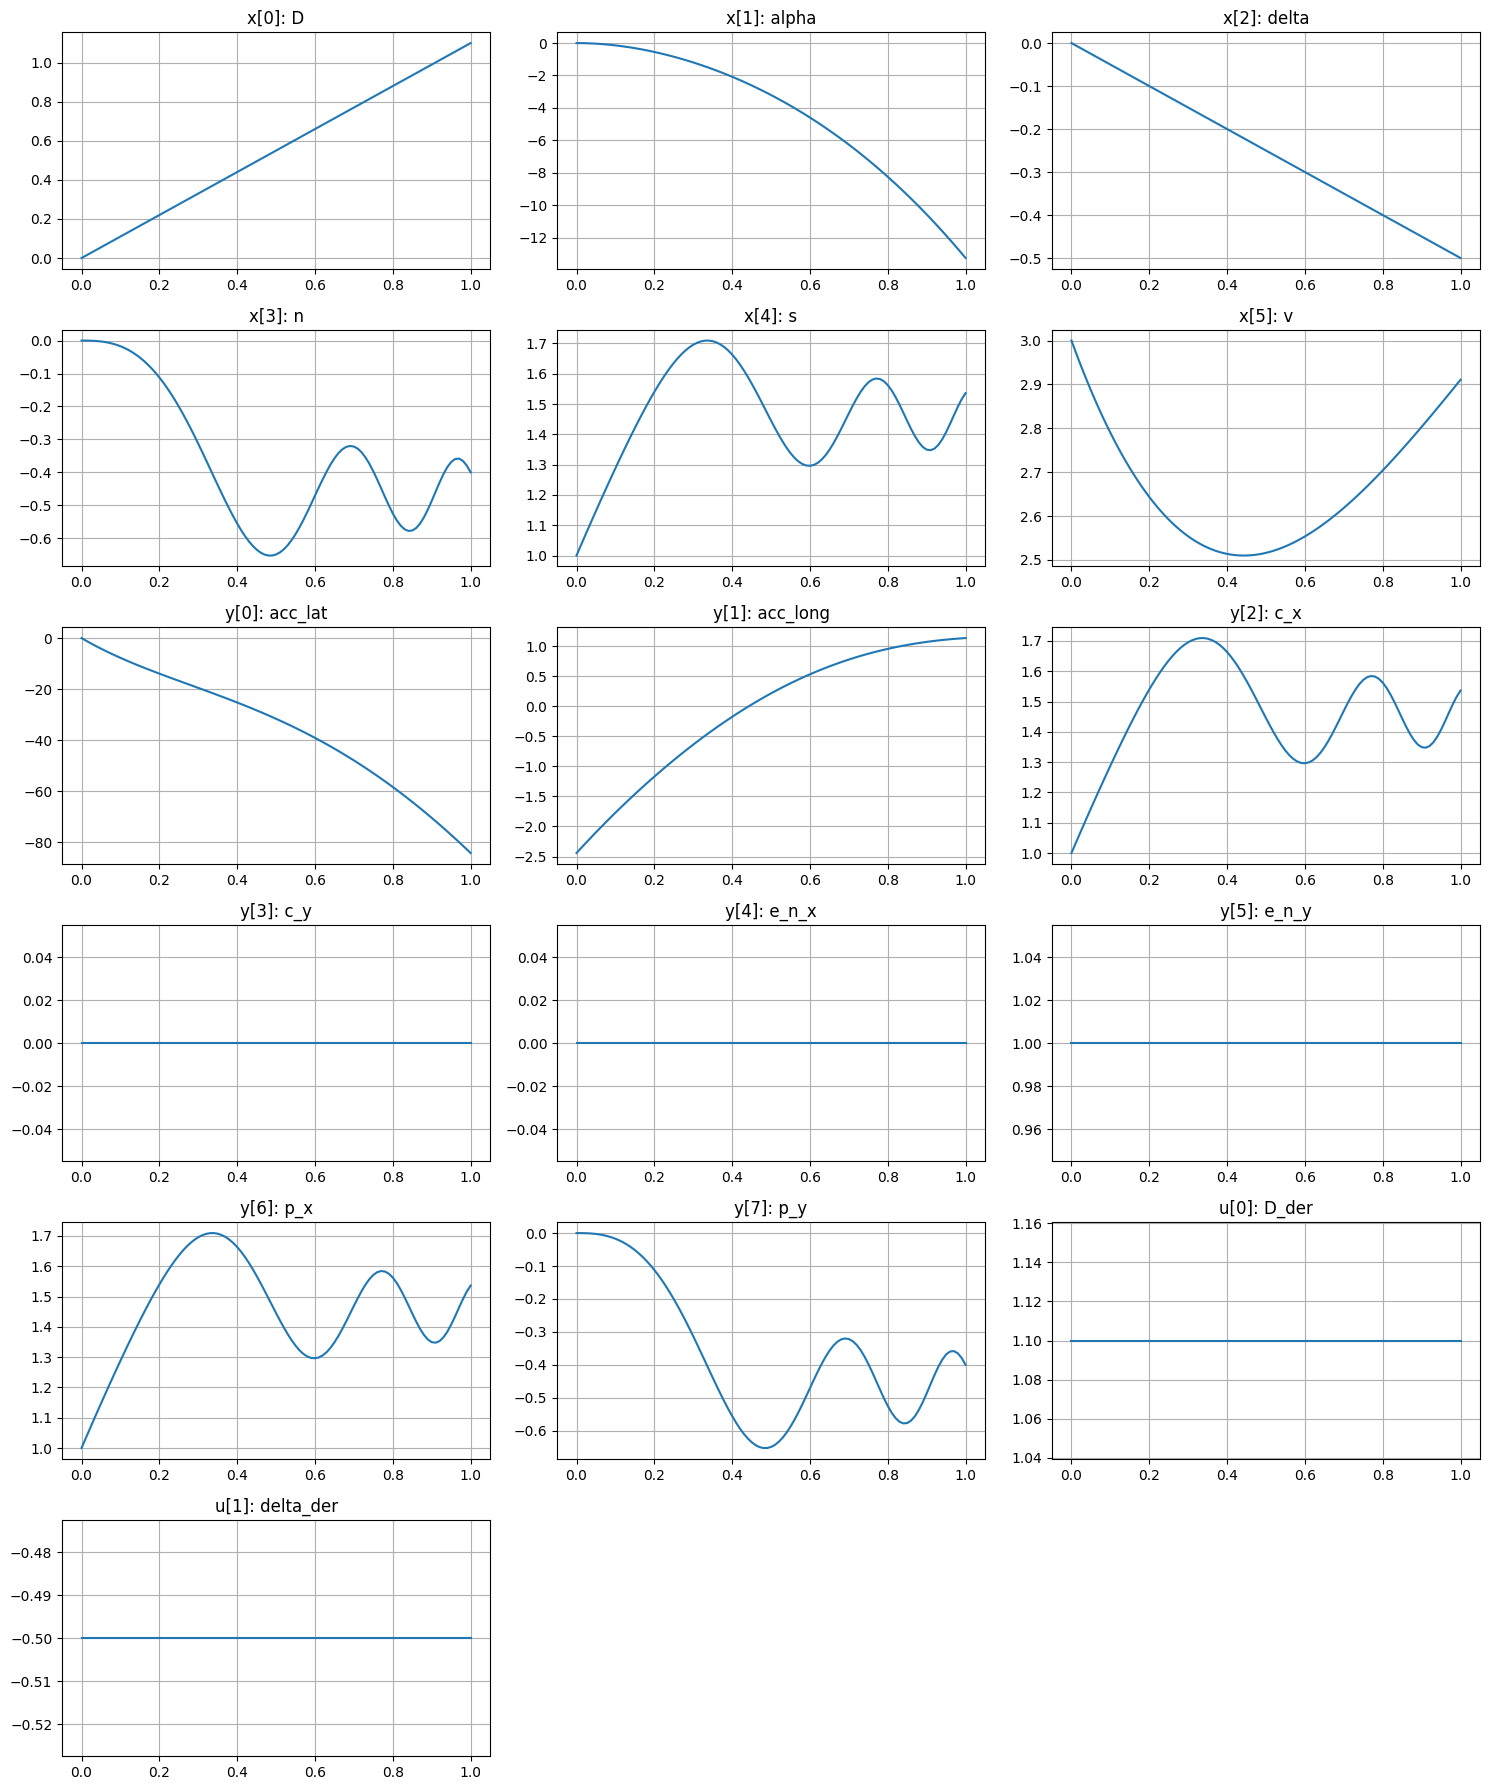

In [22]:
# Simple plot function to visualize results
import matplotlib.pyplot as plt
def plot_traj(traj, v = None, columns = 3):
  # What to plot? By default everything
  if v is None: v = x + y + u
  # Number of figures
  nfig = len(v)
  # Plot with multiple columns
  ncol = min(columns, nfig)
  nrow = nfig // ncol + (nfig % ncol > 0)
  fig = plt.figure(figsize=(15, max(10, 3*nrow)), tight_layout=True)
  for k, n in enumerate(v):
    ax = fig.add_subplot(nrow, ncol, k + 1)
    if n in x:
      # Plotting a state
      vtype = 'x'
      k = x.index(n)
      ax.plot(tout, traj[n])
    elif n in u:
      # Plotting a control
      vtype = 'u'
      k = u.index(n)
      ax.step(tout, traj[n])
    elif n in y:
      # Plotting an output
      vtype = 'y'
      k = y.index(n)
      ax.plot(tout, traj[n])
    else:
      raise ValueError(f'Variable {n} not found in x, y or u')
    ax.set_title(f'{vtype}[{k}]: {n}')
    ax.grid(True)

# Plot initial simulation
plot_traj(traj_sim)

## Forward sensitivity analysis 
Recall:
$$
\underbrace{\left[x(t^{\text{out}}_0), x(t^{\text{out}}_1), \ldots, x(t^{\text{out}}_{N-1})\right]}_{\texttt{xf}} = F(\underbrace{x(t_0)}_{\texttt{x0}}, u)
$$

With forward sensitivity analysis, we can calculate Jacobian-times-vector products for the simulation problem. For the above problem, this means calculating:
$$
\texttt{fwd\_xf} = \frac{\partial F(x(t_0), u)}{\partial x(t_0)} \, \texttt{fwd\_x0} +
\frac{\partial F(x(t_0), u)}{\partial u} \, \texttt{fwd\_u}
$$

In CasADi, we can use the syntax *\<CasADi function\>.forward($n$)* to generate a new function that calculates $n$ forward directional derivatives. If you embed an integrator into an optimization formulation, such calls are done internally. For example, if we wanted to find the derivatives of *all* outputs with respect to the initial velocity, this could be calculated as follows:


In [23]:
# Generate a function for forward directional derivatives:
fwd_F = F.forward(1)
print(fwd_F)

# Select forward sensitivities
fwd_x0 = np.array([1 if n=='v' else 0 for n in x])
fwd_u = np.zeros(u_sim.shape)
print('fwd_x0: ', fwd_x0)
print('fwd_u: ', fwd_u)

# Evaluate the function
fwd_xf = fwd_F(x0=x0, u=u_sim, out_xf = xf_sim, fwd_x0 = fwd_x0, fwd_u = fwd_u)['fwd_xf']
print('fwd_xf: ', fwd_xf)

# Sensitivity of v at end w.r.t. initial v
print('dv(t_end)/dv(t0): ', fwd_xf[x.index('v'), -1])


fwd1_F:(x0[6],u[2x101],out_xf[6x101,0nz],fwd_x0[6],fwd_u[2x101])->(fwd_xf[6x101]) MXFunction
fwd_x0:  [0 0 0 0 0 1]
fwd_u:  [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0.]]
fwd_xf:  
[[0, -7.83543e-27, -1.22159e-26, -1.74467e-26, -2.36302e-26, -1.94258e-26, -1.52727e-26, -1.34782e-26, -1.09359e-26, -9.27636e-27, -1.44608e-26, -1.2577e-26, 1.91045e-26, 7.30344e-26, 8.41613e-26, 7.42442e-26, 7.23153e-26, 7.72224e-26, 8

Forward sensitivities analysis is equivalent to what can be calculated with finite differences, but more accurately and potentially faster, especially when many sensitivity directions are calculated 

In [24]:
# Perturb initial state
h = 1e-3
x0_pert = x0 + h * fwd_x0
u_pert = u_sim + h * fwd_u

# Using finite differences to calculate the forward sensitivities
xf_pert = F(x0_pert, u_pert)

# Finite difference approximation
fwd_xf_fd = (xf_pert - xf_sim) / h
print('fwd_xf_fd: ', fwd_xf_fd)

# Sensitivity of v at end w.r.t. initial v
print('dv(t_end)/dv(t0): ', fwd_xf_fd[x.index('v'), -1])

fwd_xf_fd:  
[[0, 1.73472e-15, 6.93889e-15, 6.93889e-15, 6.93889e-15, 1.38778e-14, 1.38778e-14, 1.38778e-14, 2.77556e-14, 2.77556e-14, 2.77556e-14, 4.16334e-14, 5.55112e-14, 5.55112e-14, 5.55112e-14, 2.77556e-14, 2.77556e-14, 0, -2.77556e-14, -2.77556e-14, -2.77556e-14, -5.55112e-14, -5.55112e-14, -5.55112e-14, -5.55112e-14, -1.11022e-13, -1.66533e-13, -1.66533e-13, -1.66533e-13, -1.66533e-13, -2.77556e-13, -2.77556e-13, -2.77556e-13, -2.77556e-13, -3.88578e-13, -3.88578e-13, -3.33067e-13, -3.33067e-13, -3.33067e-13, -3.88578e-13, -3.88578e-13, -3.88578e-13, -3.88578e-13, -4.44089e-13, -4.44089e-13, -4.44089e-13, -4.44089e-13, -4.44089e-13, -4.44089e-13, -4.44089e-13, -3.33067e-13, -3.33067e-13, -2.22045e-13, -2.22045e-13, -2.22045e-13, -1.11022e-13, -1.11022e-13, -1.11022e-13, -1.11022e-13, -3.33067e-13, -3.33067e-13, -4.44089e-13, -4.44089e-13, -5.55112e-13, -6.66134e-13, -7.77156e-13, -7.77156e-13, -7.77156e-13, -8.88178e-13, -8.88178e-13, -1.11022e-12, -1.11022e-12, -1.22125e-12, -

## Adjoint sensitivity analysis
Recall:
$$
\underbrace{\left[x(t^{\text{out}}_0), x(t^{\text{out}}_1), \ldots, x(t^{\text{out}}_{N-1})\right]}_{\texttt{xf}} = F(\underbrace{x(t_0)}_{\texttt{x0}}, u)
$$

With *adjoint* sensitivity analysis, we can calculate transposed Jacobian-times-vector products for the simulation problem. For the above problem, this means calculating:
$$
\texttt{adj\_x0} = \left(\frac{\partial F(x(t_0), u)}{\partial x(t_0)}\right)^T \, \texttt{adj\_xf} \quad \text{and} \quad
\texttt{adj\_u} = \left(\frac{\partial F(x(t_0), u)}{\partial u}\right)^T \, \texttt{adj\_xf}
$$

In CasADi, we can use the syntax *\<CasADi function\>.reverse($m$)* to generate a new function that calculates $m$ adjoint directional derivatives. If you embed an integrator into an optimization formulation, such calls are done internally.

For our example, if we wanted to find the final velocity with respect to *all* the inputs, it could be done as follows:

In [25]:
# Generate a function for adjoint directional derivatives:
adj_F = F.reverse(1)
print(adj_F)

# Select adjoint sensitivities
adj_xf = np.zeros(xf_sim.shape)
adj_xf[x.index('v'), -1] = 1

# Evaluate the function
res_adj_F = adj_F(x0=x0, u=u_sim, out_xf = xf_sim, adj_xf = adj_xf)
adj_x0 = res_adj_F['adj_x0']
adj_u = res_adj_F['adj_u']
print('adj_x0: ', adj_x0)
print('adj_u: ', adj_u)

# Sensitivity of v at end w.r.t. initial v
print('dv(t_end)/dv(t0): ', adj_x0[x.index('v')])

adj1_F:(x0[6],u[2x101],out_xf[6x101,0nz],adj_xf[6x101])->(adj_x0[6],adj_u[2x101]) MXFunction
adj_x0:  [1.31648, 0, 0.0249561, 0, 0, 0.138441]
adj_u:  
[[0, 0.0131437, 0.0131008, 0.0130569, 0.0130119, 0.0129658, 0.0129186, 0.0128704, 0.012821, 0.0127705, 0.0127189, 0.0126661, 0.0126122, 0.0125571, 0.0125008, 0.0124434, 0.0123847, 0.0123248, 0.0122637, 0.0122013, 0.0121377, 0.0120727, 0.0120065, 0.0119389, 0.01187, 0.0117998, 0.0117282, 0.0116552, 0.0115808, 0.0115049, 0.0114277, 0.0113489, 0.0112687, 0.0111869, 0.0111037, 0.0110188, 0.0109324, 0.0108444, 0.0107548, 0.0106635, 0.0105705, 0.0104758, 0.0103794, 0.0102812, 0.0101812, 0.0100794, 0.0099757, 0.00987012, 0.00976262, 0.00965313, 0.00954166, 0.00942817, 0.00931257, 0.00919487, 0.00907502, 0.00895296, 0.00882866, 0.00870208, 0.00857315, 0.00844185, 0.00830812, 0.00817189, 0.00803315, 0.00789182, 0.00774783, 0.00760117, 0.00745173, 0.00729947, 0.00714434, 0.00698625, 0.00682514, 0.00666095, 0.0064936, 0.00632303, 0.00614914, 0.0059

## FMI export and reimport

* If you have a dynamic model expressed in CasADi symbolics, you can use CasADi to generate an FMI
  - Possibly exported from Modelica, using Modelon Impact/OCT or Pymoca or (in development) Rumoca 
  - Extension of CasADi's C code export
  - FMI 3.0, with efficient forward and adjoint derivative calculations
* FMI export is a new feature in CasADi
  - But builds on mature functionality, such as algorithmic differentiation (AD) and C code export
  - Be prepared to use a development version of CasADi, e.g. a [nightly build](https://github.com/casadi/casadi/releases/tag/nightly-main)


In [26]:
# Install CasADi nightly build (uncomment if needed)
#!pip install casadi-3.7.0.dev+main-cp311-none-manylinux2014_x86_64.whl

You may need to restart the Python kernel.

### Race car example with FMU export
* To use FMI export in CasADi, first construct a DaeBuilder instance symbolically by declaring model variables and adding equations.
* If you know Modelica/FMI, the syntax should look familiar

We illustrate using a CasADi implementation of the race car model from above.

In [27]:
# CasADi/DaeBuilder implementation of the Kloeser2020 model
with open('kloeser2020.py', 'r') as myfile: print(myfile.read())

import casadi as ca
from zipfile import ZipFile
from pathlib import Path
import os
import numpy as np

# Create DaeBuilder instance with symbolic representation of the model
dae = ca.DaeBuilder('kloeser2020_casadi')

# States
s = dae.add('s', dict(start = 0, initial = 'exact', description = 'Tangential position'))
n = dae.add('n', dict(start = 0, initial = 'exact', description = 'Normal position'))
alpha = dae.add('alpha', dict(start = 0, initial = 'exact', description = 'Heading'))
v = dae.add('v', dict(start = 0, initial = 'exact', description = 'Speed'))

D = dae.add('D', dict(min = -1, max = 1, description = 'Duty cycle of electric motor'))
delta = dae.add('delta', dict(min = -0.8, max = 0.8, description = 'Steering angle'))


# Controls
D_der = dae.add('D_der', 'input', dict(min = -20, max = 20, description = 'Rate of electric motor duty cycle'))
delta_der = dae.add('delta_der', 'input', dict(min = -4, max = 4, description = 'Rate of steering angle'))

# Outputs
acc_long = dae.add

Let's run the above script to generate the FMU.

In [28]:
run kloeser2020.py

nx = 6, nz = 8, nq = 0, ny = 8, np = 0, nc = 0, nd = 0, nw = 7, nu = 2
Model variables:
  x = [s, n, alpha, v, D, delta]
  z = [acc_long, acc_lat, p_x, p_y, c_x, c_y, e_n_x, e_n_y]
  w = [kappa_c, der(s), der(n), der(alpha), der(v), der(D), der(delta)]
  u = [D_der, delta_der]
List of dependent variables (w):
  kappa_c := @1=6.93147, @2=6.93147, ((1+(logsumexp((@1*vertcat(-1, (-(logsumexp((@2*vertcat(-1, (-(-10*sin(s))))))/@2)))))/@1))/2)
  der(s) := ((v*cos((alpha+(0.5*delta))))/(1-(n*kappa_c)))
  der(n) := (v*sin((alpha+(0.5*delta))))
  der(alpha) := @1=(0.5*delta), (((v/0.025)*sin(@1))-(kappa_c*((v*cos((alpha+@1)))/(1-(n*kappa_c)))))
  der(v) := ((((((0.28-(0.05*v))*D)-(0.011*sq(v)))-(0.006*tanh((5*v))))/0.043)*cos((0.5*delta)))
  der(D) := D_der
  der(delta) := delta_der
Time derivatives of differential states (x):
  s: der(s)
  n: der(n)
  alpha: der(alpha)
  v: der(v)
  D: der(D)
  delta: der(delta)
Outputs (y):
  acc_long: acc_long
  acc_lat: acc_lat
  p_x: p_x
  p_y: p_y
  c_x:

CasADi - 2025-09-08 17:07:20 WARNING("FMU generation is experimental and incomplete") [.../casadi/core/dae_builder_internal.cpp:964]


### FMU reimport

 * CasADi generated FMUs are standard FMUs ...
   - can be used in any tool that supports FMI for model exchange, version 3.0
 * .. but *also* include the serialized CasADi expressions
   - Permitted by the FMI standard, following the *layered standards* approach
 * If you import a CasADi generated FMU into CasADi, you get the symbolic expressions back
   - Less overhead
   - More derivative information, including higher order
   - C code export
   - Interface with tools that expect CasADi expressions, e.g. ACADOS

Let's reimport the FMU produced by the kloeser2020.py script:

In [29]:
# Import a CasADi generated FMU 
dae_ca = ca.DaeBuilder('racecar_ca', 'fmus/kloeser2020_casadi.fmu')
dae_ca.disp(True)

nx = 6, nz = 0, nq = 0, ny = 8, np = 0, nc = 0, nd = 0, nw = 15, nu = 2
Model variables:
  x = [s, n, alpha, v, D, delta]
  w = [acc_long, acc_lat, kappa_c, p_x, p_y, c_x, c_y, e_n_x, e_n_y, der(s), der(n), der(alpha), der(v), der(D), der(delta)]
  u = [D_der, delta_der]
List of dependent variables (w):
  acc_long := (((((0.28-(0.05*v))*D)-(0.011*sq(v)))-(0.006*tanh((5*v))))/0.043)
  acc_lat := @1=(0.5*delta), (((sq(v)/0.025)*sin(@1))+((((((0.28-(0.05*v))*D)-(0.011*sq(v)))-(0.006*tanh((5*v))))*sin(@1))/0.043))
  kappa_c := @1=6.93147, @2=6.93147, ((1+(logsumexp((@1*vertcat(-1, (-(logsumexp((@2*vertcat(-1, (-(-10*sin(s))))))/@2)))))/@1))/2)
  p_x := @1=fmod(s,12.5664), @2=(@1<3.14159), @3=(@1<6.28319), @4=(@1<9.42478), @5=(@1<3.14159), @6=(@1<6.28319), @7=(@1<9.42478), (((@2?vertcat(@1, 0):0)+((!@2)?((@3?vertcat((3.14159+sin((s-3.14159))), (1-cos((s-3.14159)))):0)+((!@3)?((@4?vertcat((9.42478-@1), 2):0)+((!@4)?vertcat((-sin((s-9.42478))), (1+cos((s-9.42478)))):0)):0)):0))[0]+(n*((@5?[0,

For DaeBuilder instances that contain the symbolic representation, the `create` function will return a symbolic CasADi function (`MXFunction`) instead of an `FmuFunction`:

In [30]:
f_ca = dae_ca.create('f_ca', ['x', 'u'], ['ode', 'y'])
print(f_ca)

f_ca:(x[6],u[2])->(ode[6],y[8]) MXFunction


In [31]:
# Note how f_ca is a regular CasADi function, so we could for example extract the expressions
[x_ex, u_ex] = f_ca.mx_in()
[ode_ex, y_ex] = f_ca.call([x_ex, u_ex])

print(ode_ex)


@1=(0.5*delta), @2=6.93147, @3=6.93147, @4=((1+(logsumexp((@2*vertcat(-1, (-(logsumexp((@3*vertcat(-1, (-(-10*sin(s))))))/@3)))))/@2))/2), @5=((v*cos((alpha+@1)))/(1-(n*@4))), vertcat(@5, (v*sin((alpha+@1))), (((v/0.025)*sin(@1))-(@4*@5)), ((((((0.28-(0.05*v))*D)-(0.011*sq(v)))-(0.006*tanh((5*v))))/0.043)*cos(@1)), D_der, delta_der)


## Event support (Work-in-progress)

Currently working to extend the CasADi FMI support to handle system with events:
  * Main challenge: Extending CasADi sensitivity analysis to handle events

Example: Exporting the bouncing ball from CasADi:

nx = 2, nz = 0, nq = 0, ny = 2, np = 0, nc = 0, nd = 0, nw = 2, nu = 0
Model variables:
  t = [t]
  x = [h, v]
  w = [der(h), der(v)]
List of dependent variables (w):
  der(h) := v
  der(v) := -9.81
Time derivatives of differential states (x):
  h: der(h)
  v: der(v)
Outputs (y):
  h: h
  v: v
nx = 2, nz = 0, nq = 0, ny = 2, np = 0, nc = 0, nd = 0, nw = 2, nu = 0
Model variables:
  t = [t]
  x = [h, v]
  w = [der(h), der(v)]
List of dependent variables (w):
  der(h) := v
  der(v) := -9.81
Time derivatives of differential states (x):
  h: der(h)
  v: der(v)
Outputs (y):
  h: h
  v: v
When equations:
  when h < 0 : 
    v := (-0.8*v)


CasADi - 2025-09-08 17:07:21 WARNING("DaeBuilder::pre has not been implemented: Returning identity mapping") [.../casadi/core/dae_builder.cpp:833]
CasADi - 2025-09-08 17:07:21 WARNING("Event support is experimental") [.../casadi/core/integrator.cpp:752]


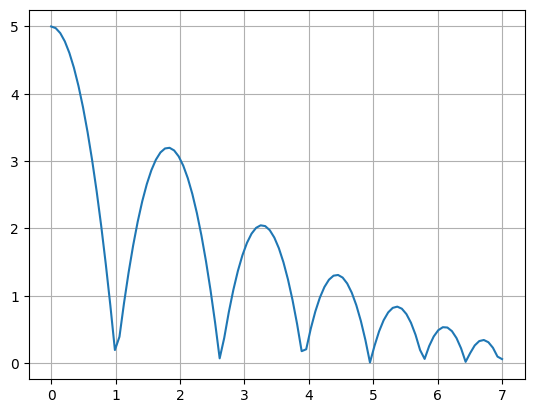

In [32]:
# Start with an empty DaeBuilder instance
bb = ca.DaeBuilder('bouncing_ball')

# Model variables
t = bb.add('t', 'independent')
h = bb.add('h', 'output', dict(start = 5, initial = 'exact'))
v = bb.add('v', 'output', dict(start = 0, initial = 'exact'))

# Dynamic equations
bb.eq(bb.der(h), v)
bb.eq(bb.der(v), -9.81)
bb.disp(True)

# Event dynamics: When h < 0, reinitialize v to -0.8*v
bb.when(h < 0, [bb.reinit('v', -0.8*bb.pre(v))])
bb.disp(True)

# Simulate over 7s
tgrid = np.linspace(0, 7, 100)
sim = ca.integrator('sim', 'cvodes', bb.create(), 0, tgrid,
                    dict(transition = bb.transition()))
simres = sim(x0 = bb.start(bb.x()))

# Visualize the solution
plt.figure(1)
plt.clf()
plt.plot(tgrid, simres['xf'][0, :].T)
plt.grid()
plt.show()


* Can be exported as FMU and simulated with e.g. FMPy - see CasADi examples collection
* Proof-of-concept support for analytical sensitivity calculations, embedding in optimization problems
* For details, see paper from the [American Modelica Conference, 2024](https://ecp.ep.liu.se/index.php/modelica/article/view/1135)

## New high-level software framework: FMIOPT
 * New, higher level FMI optimization framework
   - CasADi knowledge not necessary
 * In development since 2024 together with a motorsports partner
 * Commercial (closed source) framework, builds on CasADi FMI interoperability
 * Key goals:
   - Enable efficient user workflows that start with existing (imperfect) simulation models
   - State-of-the-art diagnostics: User should get correct answer or *actionable* diagnostics
   - Numerical efficiency, cloud deployment
   - *Scalability* of both numerical solution workflows and of support/diagnostics
 * Supported by new Norwegian company: FMIOPT AS
 * Contact joel@fmiopt.com if your company is interested in becoming a pilot user
 * Public announcement with details in 2026

##